## This is the implementation of K-means with MapReduce

In [1]:
import pyspark
from pyspark import SparkContext
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
sc = SparkContext.getOrCreate()

In [3]:
'''This is the distance function'''
def Map_distance(x,mu):
    n_data=mu.shape[0]
    distances= np.zeros(n_data)
    for i in range (n_data):
        distances[i]= np.sum((x-mu[i])*(x-mu[i])) 
        #This is technically the square of the l2 distance. It changes the numbers 
        #but not the order. 
        
    return (np.argmin(distances),(x,1))


In [4]:
'''This is the reduce function. It will sum the coordinates of the points in every cluster but also the number 1, which 
was added by the Map_distance function at the end, providing the total number of the points in the cluster'''
def Reduce(x):
    return [sum(i) for i in zip(*x)]

In [5]:
'''This function takes the sum of the coordinates and the number of points from the Reduce step to get the averages'''
def means(x):
    x=list(x)
    return x[0][0] / x[0][1]

In [6]:
'''This function takes the centroid coordinates from the "collect()" method'''
def GetCentroids(x):
    return np.array([i[1] for i in x])

In [7]:
'''This function plots the first two coordinates. We chose to plot the first two coordinates to have a nice visualization'''
def plot_clusters(clusters,centroids):
    plt.figure(figsize=(7,7))
    
    for cluster in clusters:
        #The cluster is the form of a tuple (NUM_CLUSTER,<pyspark.resultiterable.ResultIterable object> here
        #First element is a list of arrays, the second is a tuple of ones. We don't need it for the plot
        cluster=list(zip(*cluster[1]))[0]
        #We now chose to plot only the first two features.
        x=[]
        y=[]
        for point in cluster:
            x.append(point[0])
            y.append(point[1])
        plt.scatter(x,y)
    x=[]
    y=[]
    for centroid in centroids:
        x.append(centroid[0])
        y.append(centroid[1])
   
    plt.scatter(x,y, marker="x", color="black")
    plt.show()

In [8]:
'''This is the KMeans algorithm with MapReduce'''
def KMeans(data,x,n_centroids,itmax=6):
    centroids=data[np.random.choice(data.shape[0],n_centroids),:]
    loop=True
    i=0
    while loop and itmax!=i:
        i+=1
        MAP=x.map(lambda x: Map_distance(x,centroids))
        cluster_groups= MAP.groupByKey()
        plot_clusters(cluster_groups.collect(),centroids)
        REDUCE=cluster_groups.mapValues(lambda x: Reduce(x))
        new_centroids = GetCentroids(REDUCE.groupByKey().mapValues(lambda x: means(x)).collect())
        if np.all(new_centroids != centroids):
            centroids=new_centroids
        else:
            pass

                                       

The svd_2000 array is the same we used in Question2.

In [10]:
svd_2000

array([[ 0.79802402, -0.72416001, -0.53294086, ..., -0.06468016,
        -0.09300093,  0.06236753],
       [ 0.33268248, -0.10413722, -0.12906512, ..., -0.06672143,
         0.06843486,  0.00778948],
       [ 0.50318465,  0.14270771,  0.06942716, ..., -0.00311097,
         0.20146188, -0.17983804],
       ...,
       [ 0.86766648, -0.44662712,  0.23747693, ..., -0.10378765,
        -0.09291937, -0.05362097],
       [ 1.6396915 , -1.20430156, -0.56937974, ...,  0.10622452,
         0.02296928, -0.19493863],
       [ 0.23247929, -0.12651156, -0.03832464, ..., -0.0327698 ,
        -0.04588909, -0.02429934]])

In [11]:
points_dist = sc.parallelize(svd_2000)

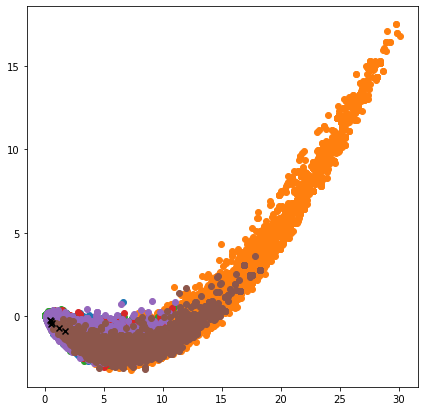

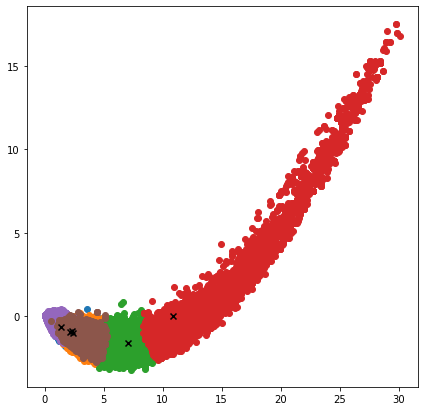

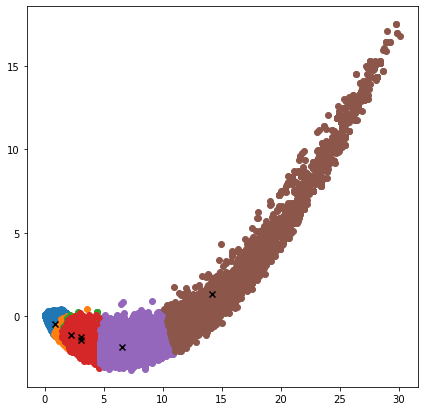

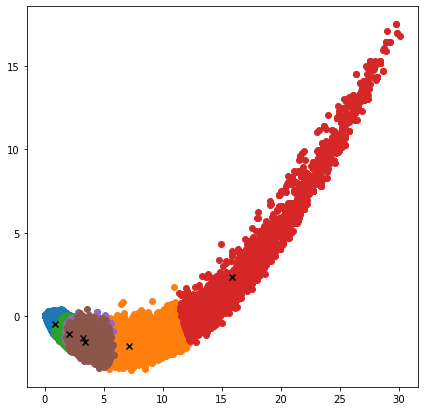

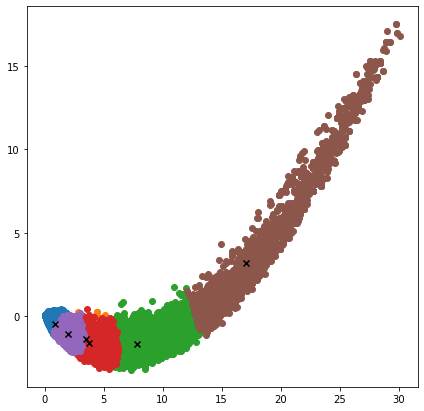

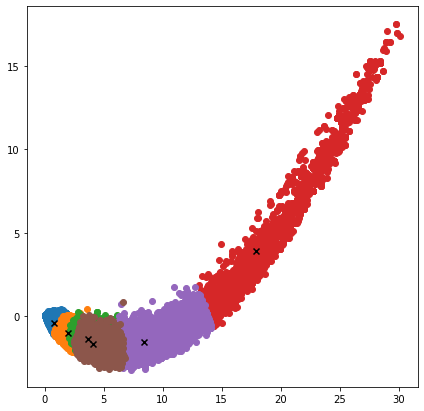

In [12]:
KMeans(svd_2000,points_dist, 6)